## 1️⃣ Setup & Data Loading

In [25]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Time series libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [26]:
# Load time series data
df_state = pd.read_csv('cleaned_data/state_timeseries.csv')
df_national = pd.read_csv('cleaned_data/national_timeseries.csv')

print("📊 Data loaded successfully!")
print(f"\nState-level: {len(df_state):,} rows")
print(f"States: {df_state['state'].nunique()}")
print(f"Years: {df_state['year'].nunique()}")

print(f"\nNational-level: {len(df_national):,} rows")
print(f"Years: {df_national['year'].nunique()}")

📊 Data loaded successfully!

State-level: 112 rows
States: 14
Years: 8

National-level: 8 rows
Years: 8


In [27]:
# Preview data
print("State-level data:")
display(df_state.head(10))

print("\nNational-level data:")
display(df_national)

State-level data:


,state,year,crimes
0,Johor,2016,10121
1,Johor,2017,8729
2,Johor,2018,8458
3,Johor,2019,7947
4,Johor,2020,5966
5,Johor,2021,3440
6,Johor,2022,3489
7,Johor,2023,4102
8,Kedah,2016,6201
9,Kedah,2017,5763



National-level data:


,year,crimes
0,2016,90028
1,2017,77804
2,2018,71760
3,2019,66967
4,2020,52664
5,2021,41848
6,2022,40465
7,2023,41991


---
## 2️⃣ Exploratory Time Series Analysis

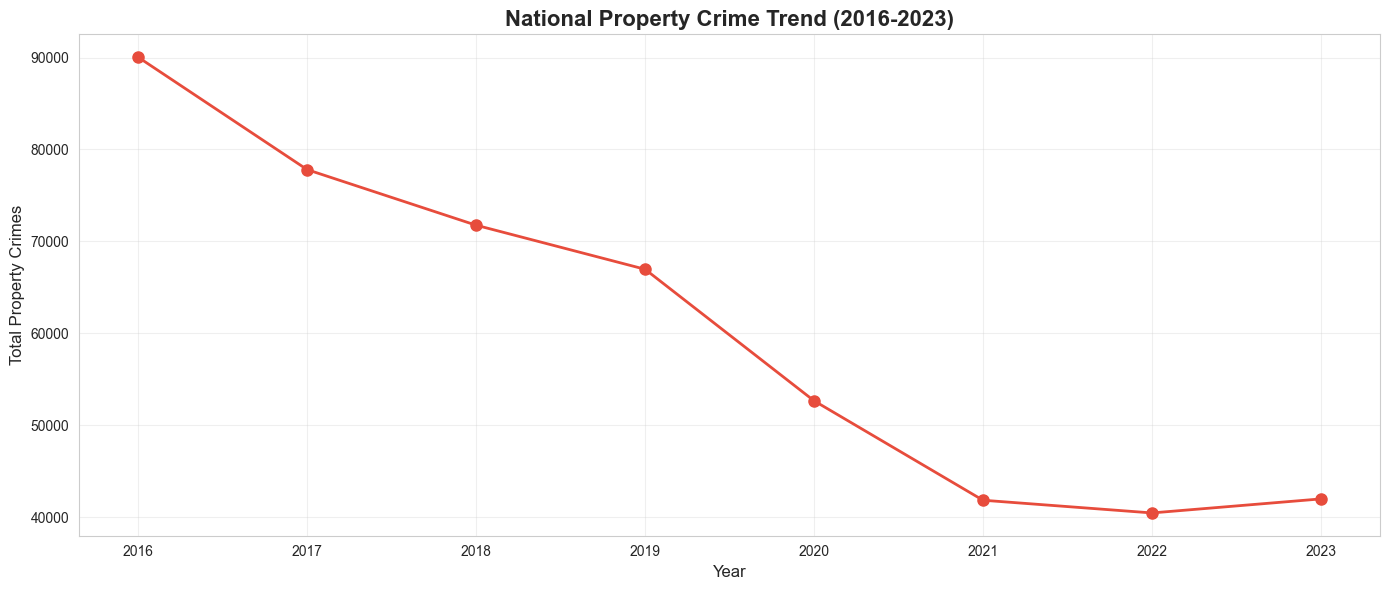


📈 Trend Analysis:
Starting value (2016): 90,028
Ending value (2023): 41,991
Overall change: -53.4%


In [28]:
# National trend visualization
plt.figure(figsize=(14, 6))
plt.plot(df_national['year'], df_national['crimes'], marker='o', linewidth=2, markersize=8, color='#e74c3c')
plt.title('National Property Crime Trend (2016-2023)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Property Crimes', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📈 Trend Analysis:")
print(f"Starting value (2016): {df_national.iloc[0]['crimes']:,.0f}")
print(f"Ending value (2023): {df_national.iloc[-1]['crimes']:,.0f}")
print(f"Overall change: {((df_national.iloc[-1]['crimes'] / df_national.iloc[0]['crimes']) - 1) * 100:.1f}%")

In [29]:
# Top 5 states by total crime
state_totals = df_state.groupby('state')['crimes'].sum().sort_values(ascending=False).head(5)

print("🏆 Top 5 States by Total Property Crimes (2016-2023):")
for i, (state, total) in enumerate(state_totals.items(), 1):
    print(f"{i}. {state}: {total:,.0f}")

🏆 Top 5 States by Total Property Crimes (2016-2023):
1. Selangor: 122,286
2. W.P. Kuala Lumpur: 58,480
3. Johor: 52,252
4. Sarawak: 37,098
5. Kedah: 36,003


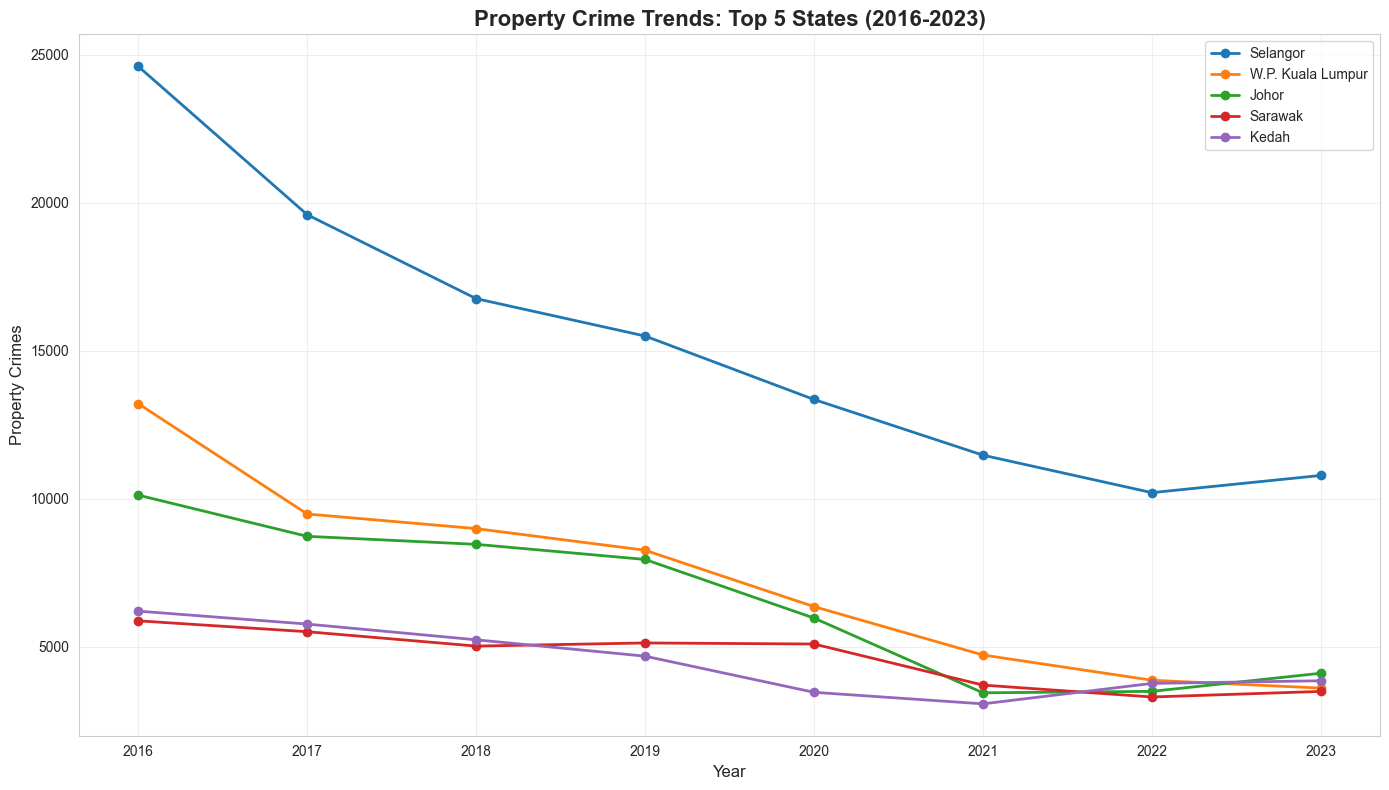

In [30]:
# Visualize top 5 states trends
top_states = state_totals.index.tolist()
df_top_states = df_state[df_state['state'].isin(top_states)]

plt.figure(figsize=(14, 8))
for state in top_states:
    state_data = df_top_states[df_top_states['state'] == state]
    plt.plot(state_data['year'], state_data['crimes'], marker='o', label=state, linewidth=2)

plt.title('Property Crime Trends: Top 5 States (2016-2023)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Property Crimes', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 3️⃣ Stationarity Testing

**Purpose:** Check if time series is stationary (constant mean, variance, autocorrelation)

**Method:** Augmented Dickey-Fuller (ADF) test

**Interpretation:** p-value < 0.05 = stationary (good for ARIMA)

In [31]:
# Test stationarity for national series
def test_stationarity(series, series_name):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    result = adfuller(series.dropna())
    
    print(f"\n{'='*60}")
    print(f"Stationarity Test: {series_name}")
    print(f"{'='*60}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    
    if result[1] < 0.05:
        print(f"\n✅ Series is STATIONARY (p < 0.05)")
        print("   → No differencing needed for ARIMA")
    else:
        print(f"\n⚠️  Series is NON-STATIONARY (p >= 0.05)")
        print("   → Differencing recommended (d=1 in ARIMA)")
    
    return result[1] < 0.05

# Test national series
is_stationary_national = test_stationarity(df_national['crimes'], "National Property Crimes")


Stationarity Test: National Property Crimes
ADF Statistic: -1.3288
p-value: 0.6159
Critical Values:
  1%: -6.0451
  5%: -3.9293
  10%: -2.9868

⚠️  Series is NON-STATIONARY (p >= 0.05)
   → Differencing recommended (d=1 in ARIMA)


In [32]:
# Test stationarity for top 3 states
top_3_states = state_totals.head(3).index.tolist()

stationarity_results = {}
for state in top_3_states:
    state_series = df_state[df_state['state'] == state]['crimes']
    is_stationary = test_stationarity(state_series, f"{state} State")
    stationarity_results[state] = is_stationary


Stationarity Test: Selangor State
ADF Statistic: -1.8574
p-value: 0.3523
Critical Values:
  1%: -6.0451
  5%: -3.9293
  10%: -2.9868

⚠️  Series is NON-STATIONARY (p >= 0.05)
   → Differencing recommended (d=1 in ARIMA)

Stationarity Test: W.P. Kuala Lumpur State
ADF Statistic: -6.5666
p-value: 0.0000
Critical Values:
  1%: -6.0451
  5%: -3.9293
  10%: -2.9868

✅ Series is STATIONARY (p < 0.05)
   → No differencing needed for ARIMA

Stationarity Test: Johor State
ADF Statistic: 0.6588
p-value: 0.9890
Critical Values:
  1%: -6.0451
  5%: -3.9293
  10%: -2.9868

⚠️  Series is NON-STATIONARY (p >= 0.05)
   → Differencing recommended (d=1 in ARIMA)


---
## 4️⃣ ACF/PACF Analysis

### 🎯 What Are We Doing?
We're analyzing **autocorrelation patterns** to determine which ARIMA parameters to use for forecasting property crimes.

---

### 🧠 Simple Explanation (For Non-Technical Audience)

**Imagine predicting tomorrow's temperature:**
- **ACF asks:** "Does today's temperature relate to yesterday's? Two days ago? Three days ago?"
- **PACF asks:** "If I ONLY look at yesterday (ignoring all other days), does it help predict today?"

**For property crimes:**
- **ACF** tells us if prediction **errors** from past years matter → guides **q** (MA term)
- **PACF** tells us if **actual crime values** from past years matter → guides **p** (AR term)

**Key insight:** With only 8 years of data, we keep p and q small (0-2) to avoid overfitting.

---

### 📚 Technical Details

**ARIMA Model Structure: ARIMA(p, d, q)**
- **p (AR):** How many past **values** to use (from PACF)
- **d (I):** How many times to **difference** the data (for stationarity)
- **q (MA):** How many past **errors** to use (from ACF)

**Reading the Plots:**

1. **ACF (Autocorrelation Function):**
   - Shows correlation between current and past values
   - **If ACF cuts off sharply after lag q** → Use MA(q)
   - Example: Significant spikes at lags 1-2 → try q=1 or q=2

2. **PACF (Partial Autocorrelation Function):**
   - Shows **direct** correlation (removes indirect effects)
   - **If PACF cuts off sharply after lag p** → Use AR(p)
   - Example: Only lag 1 significant → try p=1

**What to Look For:**
- **Significant spikes:** Bars crossing the blue confidence bands
- **Cut-off point:** Where spikes stop being significant
- **If both decay slowly:** May need differencing (d=1)

---

### 🎤 Defense Strategy (For Q&A)

**Q: "Why use ACF/PACF instead of just testing all combinations?"**

**A:** "These plots guide parameter selection to avoid overfitting. ACF identifies MA order (q), PACF identifies AR order (p). With limited data (8 years), we use these as heuristics to narrow our search space—testing only plausible configurations like (1,1,0), (0,1,1), (1,1,1) rather than exhaustively trying every combination up to ARIMA(5,2,5)."

**Q: "What if the plots are unclear?"**

**A:** "With small datasets, patterns can be noisy. That's why we validate by comparing multiple candidate models using MAPE on test data, rather than relying solely on ACF/PACF."

---

📊 Analyzing autocorrelation patterns...

Dataset: 8 observations (years 2016-2023)
Maximum useful lags: 3 (rule of thumb: n/2)


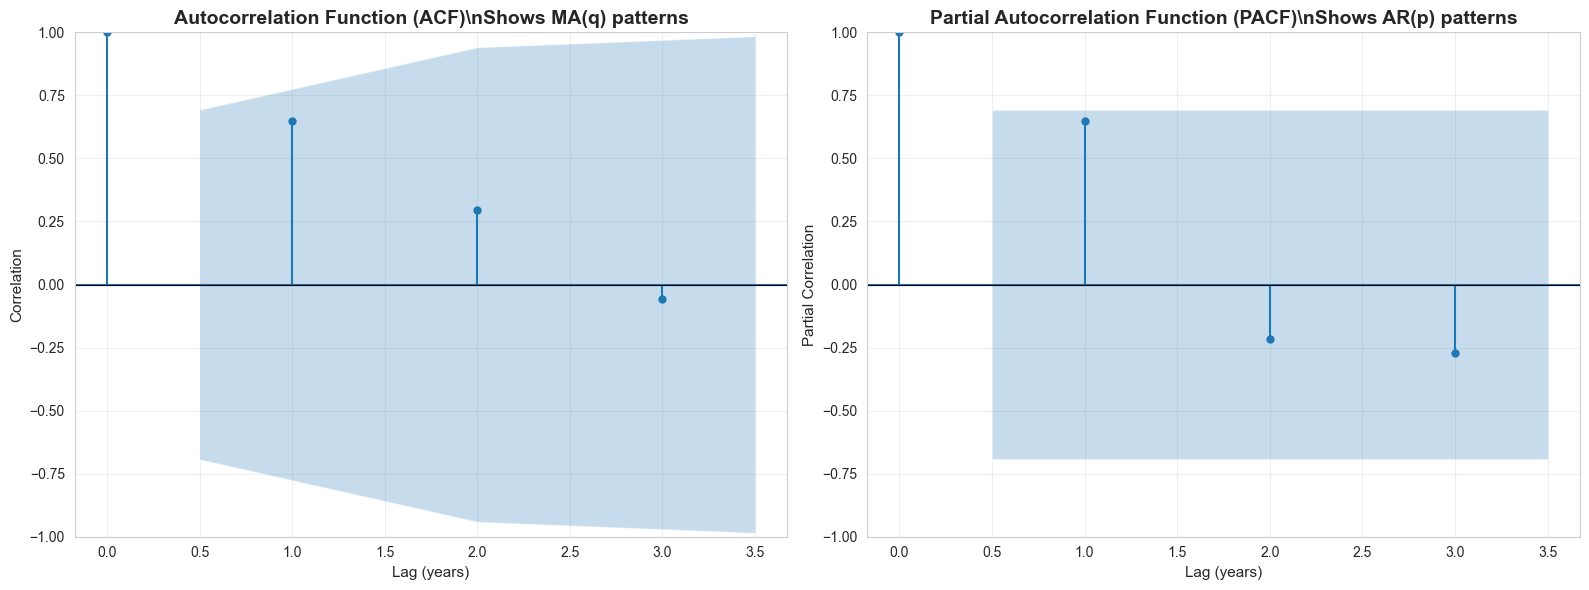


📖 HOW TO READ THESE PLOTS:

1️⃣  ACF (Left Plot) - Moving Average (MA) Order:
   • Bars = Correlation between current year and past years
   • Blue shaded area = Confidence interval (95%)
   • If bars INSIDE blue area → NOT significant
   • If bars OUTSIDE blue area → Significant correlation
   • Look for: Where significant spikes STOP → suggests q value

2️⃣  PACF (Right Plot) - AutoRegressive (AR) Order:
   • Shows DIRECT effect (removes indirect correlations)
   • Same confidence interval logic as ACF
   • Look for: Where significant spikes STOP → suggests p value

3️⃣  Decision Rules:
   • If ACF cuts off sharply at lag q → Use MA(q)
   • If PACF cuts off sharply at lag p → Use AR(p)
   • If both decay slowly → May need differencing (d=1)
   • With 8 observations → Keep p, q ≤ 2 to avoid overfitting

💡 Practical Approach:
   Since we have limited data, we'll test multiple ARIMA configurations:
   • ARIMA(0,0,0) - Baseline
   • ARIMA(1,0,0) - Simple AR
   • ARIMA(0,1,0) - Differenc

In [33]:
# Plot ACF and PACF for national series
print("📊 Analyzing autocorrelation patterns...\n")
series = df_national['crimes'].dropna()
nobs = len(series)
print(f"Dataset: {nobs} observations (years 2016-2023)")
# PACF requires nlags < nobs // 2, so cap at nobs//2 - 1
max_lag = min(nobs // 2 - 1, 6)
if max_lag < 1:
    print("Not enough observations to plot ACF/PACF (need at least 4).")
else:
    print(f"Maximum useful lags: {max_lag} (rule of thumb: n/2)")
    try:
        # Create plots with appropriate lags for small dataset
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        # Use numpy values to avoid pandas/index issues
        plot_acf(series.values, lags=max_lag, ax=axes[0], alpha=0.05)
        # Try PACF with a stable method where supported; fallback to default if not
        try:
            plot_pacf(series.values, lags=max_lag, ax=axes[1], alpha=0.05, method='ywm')
        except TypeError:
            plot_pacf(series.values, lags=max_lag, ax=axes[1], alpha=0.05)
        axes[0].set_title('Autocorrelation Function (ACF)\\nShows MA(q) patterns', 
                          fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Lag (years)', fontsize=11)
        axes[0].set_ylabel('Correlation', fontsize=11)
        axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        axes[0].grid(alpha=0.3)
        axes[1].set_title('Partial Autocorrelation Function (PACF)\\nShows AR(p) patterns', 
                          fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Lag (years)', fontsize=11)
        axes[1].set_ylabel('Partial Correlation', fontsize=11)
        axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        axes[1].grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('ACF/PACF plotting failed:', e)
        # Fallback: compute and plot using statstools directly
        from statsmodels.tsa.stattools import acf, pacf
        acfs = acf(series.values, nlags=max_lag, fft=False)
        try:
            pacfs = pacf(series.values, nlags=max_lag, method='ywm')
        except TypeError:
            pacfs = pacf(series.values, nlags=max_lag)
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        axes[0].bar(range(len(acfs)), acfs, color='#5DA5E8')
        axes[0].set_title('ACF (fallback)')
        axes[1].bar(range(len(pacfs)), pacfs, color='#F56C6C')
        axes[1].set_title('PACF (fallback)')
        plt.tight_layout()
        plt.show()

# Detailed interpretation
print("\n" + "="*70)
print("📖 HOW TO READ THESE PLOTS:")
print("="*70)
print("\n1️⃣  ACF (Left Plot) - Moving Average (MA) Order:")
print("   • Bars = Correlation between current year and past years")
print("   • Blue shaded area = Confidence interval (95%)")
print("   • If bars INSIDE blue area → NOT significant")
print("   • If bars OUTSIDE blue area → Significant correlation")
print("   • Look for: Where significant spikes STOP → suggests q value")
print("\n2️⃣  PACF (Right Plot) - AutoRegressive (AR) Order:")
print("   • Shows DIRECT effect (removes indirect correlations)")
print("   • Same confidence interval logic as ACF")
print("   • Look for: Where significant spikes STOP → suggests p value")
print("\n3️⃣  Decision Rules:")
print("   • If ACF cuts off sharply at lag q → Use MA(q)")
print("   • If PACF cuts off sharply at lag p → Use AR(p)")
print("   • If both decay slowly → May need differencing (d=1)")
print("   • With 8 observations → Keep p, q ≤ 2 to avoid overfitting")
print("\n💡 Practical Approach:")
print("   Since we have limited data, we'll test multiple ARIMA configurations:")
print("   • ARIMA(0,0,0) - Baseline")
print("   • ARIMA(1,0,0) - Simple AR")
print("   • ARIMA(0,1,0) - Differencing only")
print("   • ARIMA(1,1,0) - AR with differencing")
print("   • ARIMA(0,1,1) - MA with differencing")
print("   • ARIMA(1,1,1) - Full model")
print("   Then select best model based on test performance (MAPE).")
print("\n" + "="*70)


---
## 5️⃣ ARIMA Modeling - National Level

**Challenge:** Only 8 years of data = limited forecasting capability

**Strategy:**
- Use simple ARIMA models (low p, d, q)
- Train on 2016-2022 (7 years)
- Test on 2023 (1 year)
- Forecast 2024-2025 (2 years ahead)

In [34]:
# Prepare train-test split
train_national = df_national[df_national['year'] < 2023].copy()
test_national = df_national[df_national['year'] == 2023].copy()

print(f"Training data: {len(train_national)} years (2016-2022)")
print(f"Test data: {len(test_national)} year (2023)")
print(f"\nWill forecast 2 additional years: 2024-2025")

Training data: 7 years (2016-2022)
Test data: 1 year (2023)

Will forecast 2 additional years: 2024-2025


In [35]:
# Try multiple ARIMA configurations
arima_configs = [
    (0, 0, 0),  # Baseline (mean)
    (1, 0, 0),  # AR(1)
    (0, 1, 0),  # I(1) - first difference
    (1, 1, 0),  # ARIMA(1,1,0)
    (0, 1, 1),  # ARIMA(0,1,1)
    (1, 1, 1),  # ARIMA(1,1,1)
]

results_national = []

print("🔮 Testing ARIMA configurations...\n")
print(f"{'Config':<15} {'MAE':<12} {'RMSE':<12} {'MAPE':<12} {'Status'}")
print("="*65)

for order in arima_configs:
    try:
        # Fit model
        model = ARIMA(train_national['crimes'], order=order)
        fitted = model.fit()
        
        # Forecast 1 step (2023)
        forecast_series = fitted.forecast(steps=1)
        forecast = forecast_series.iloc[0]  # Use iloc to access first element
        
        # Calculate metrics
        actual = test_national['crimes'].values[0]
        mae = abs(forecast - actual)
        rmse = np.sqrt((forecast - actual)**2)
        mape = abs((actual - forecast) / actual) * 100
        
        results_national.append({
            'order': order,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'forecast_2023': forecast,
            'model': fitted
        })
        
        print(f"ARIMA{str(order):<10} {mae:<12.0f} {rmse:<12.0f} {mape:<12.1f}% ✓")
        
    except Exception as e:
        print(f"ARIMA{str(order):<10} {'Failed':<12} {'Failed':<12} {'Failed':<12} ✗")

# Find best model
best_model = min(results_national, key=lambda x: x['mape'])
print("\n" + "="*65)
print(f"✨ Best Model: ARIMA{best_model['order']} (MAPE: {best_model['mape']:.1f}%)")


🔮 Testing ARIMA configurations...

Config          MAE          RMSE         MAPE         Status
ARIMA(0, 0, 0)  21086        21086        50.2        % ✓
ARIMA(1, 0, 0)  360          360          0.9         % ✓
ARIMA(0, 1, 0)  1526         1526         3.6         % ✓
ARIMA(1, 1, 0)  1403         1403         3.3         % ✓
ARIMA(0, 1, 1)  1275         1275         3.0         % ✓
ARIMA(1, 1, 1)  1272         1272         3.0         % ✓

✨ Best Model: ARIMA(1, 0, 0) (MAPE: 0.9%)


In [36]:
# Forecast 2024-2025 using best model
best_fitted = best_model['model']

# Refit on full dataset (2016-2023) for final forecast
final_model = ARIMA(df_national['crimes'], order=best_model['order'])
final_fitted = final_model.fit()

# Forecast 2 years ahead
forecast_2024_2025 = final_fitted.forecast(steps=2)
forecast_ci = final_fitted.get_forecast(steps=2).conf_int(alpha=0.05)

print("🔮 Property Crime Forecast (National Level)")
print("="*60)
print(f"2024: {forecast_2024_2025.iloc[0]:,.0f} crimes")
print(f"      95% CI: [{forecast_ci.iloc[0, 0]:,.0f}, {forecast_ci.iloc[0, 1]:,.0f}]")
print(f"\n2025: {forecast_2024_2025.iloc[1]:,.0f} crimes")
print(f"      95% CI: [{forecast_ci.iloc[1, 0]:,.0f}, {forecast_ci.iloc[1, 1]:,.0f}]")

# Calculate change
change_2024 = ((forecast_2024_2025.iloc[0] / df_national.iloc[-1]['crimes']) - 1) * 100
change_2025 = ((forecast_2024_2025.iloc[1] / forecast_2024_2025.iloc[0]) - 1) * 100

print(f"\n📊 Expected Change:")
print(f"2023 → 2024: {change_2024:+.1f}%")
print(f"2024 → 2025: {change_2025:+.1f}%")

🔮 Property Crime Forecast (National Level)
2024: 43,485 crimes
      95% CI: [26,535, 60,436]

2025: 44,859 crimes
      95% CI: [21,836, 67,882]

📊 Expected Change:
2023 → 2024: +3.6%
2024 → 2025: +3.2%


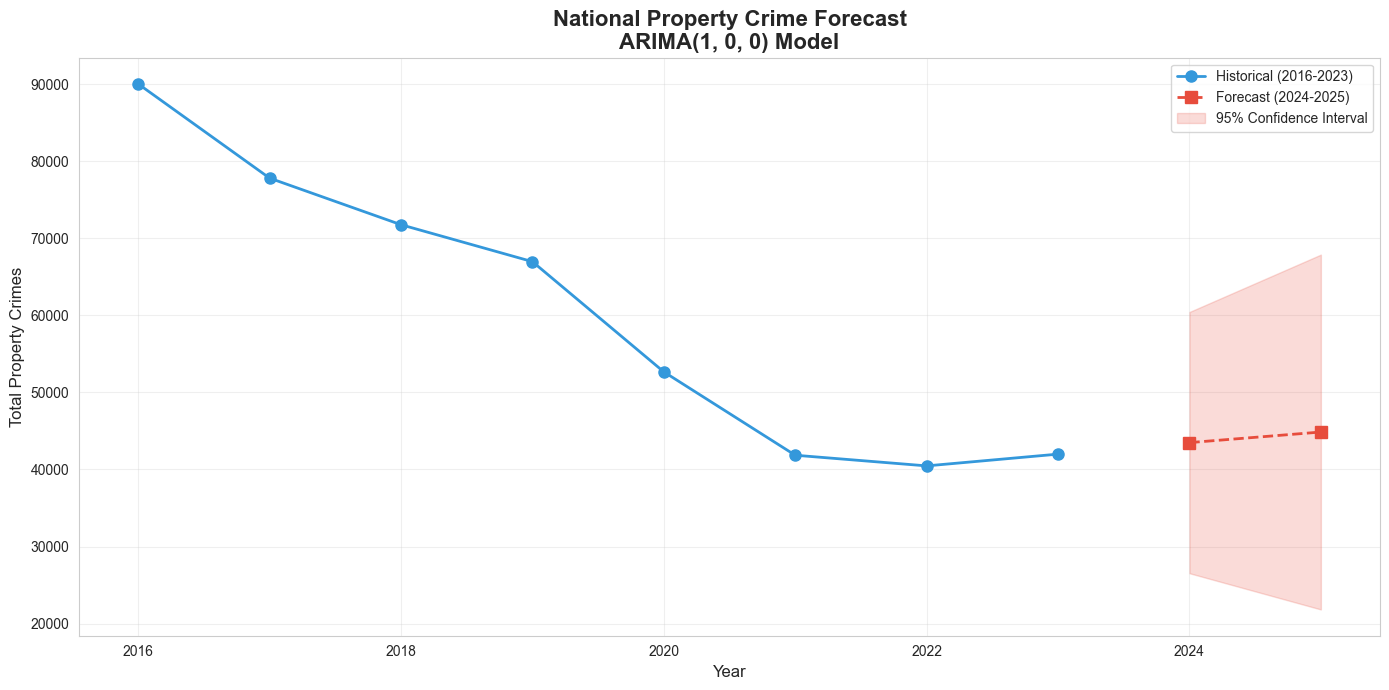

In [37]:
# Visualize forecast
plt.figure(figsize=(14, 7))

# Historical data
plt.plot(df_national['year'], df_national['crimes'], 
         marker='o', linewidth=2, markersize=8, label='Historical (2016-2023)', color='#3498db')

# Forecast
forecast_years = [2024, 2025]
plt.plot(forecast_years, forecast_2024_2025, 
         marker='s', linewidth=2, markersize=8, label='Forecast (2024-2025)', 
         color='#e74c3c', linestyle='--')

# Confidence interval
plt.fill_between(forecast_years, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 alpha=0.2, color='#e74c3c', label='95% Confidence Interval')

plt.title(f'National Property Crime Forecast\nARIMA{best_model["order"]} Model', 
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Property Crimes', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 6️⃣ State-Level Forecasting

**Focus:** Top 3 states by total crime volume

In [38]:
# Forecast top 3 states
top_3_states = state_totals.head(3).index.tolist()
state_forecasts = {}

print("🔮 State-Level Forecasts (2024-2025)\n")
print(f"{'State':<20} {'2023':<12} {'2024':<12} {'2025':<12} {'Change 24-25'}")
print("="*75)

for state in top_3_states:
    # Get state data
    state_data = df_state[df_state['state'] == state].sort_values('year')
    
    # Use best ARIMA order from national model
    try:
        model = ARIMA(state_data['crimes'], order=best_model['order'])
        fitted = model.fit()
        forecast = fitted.forecast(steps=2)
        
        state_forecasts[state] = {
            'historical': state_data,
            'forecast_2024': forecast.iloc[0],
            'forecast_2025': forecast.iloc[1],
            'actual_2023': state_data.iloc[-1]['crimes']
        }
        
        change = ((forecast.iloc[1] / forecast.iloc[0]) - 1) * 100
        
        print(f"{state:<20} {state_data.iloc[-1]['crimes']:<12.0f} {forecast.iloc[0]:<12.0f} "
              f"{forecast.iloc[1]:<12.0f} {change:+.1f}%")
        
    except Exception as e:
        print(f"{state:<20} {'Failed to forecast':<50}")

🔮 State-Level Forecasts (2024-2025)

State                2023         2024         2025         Change 24-25
Selangor             10786        11159        11501        +3.1%
W.P. Kuala Lumpur    3600         3940         4248         +7.8%
Johor                4102         4406         4673         +6.0%


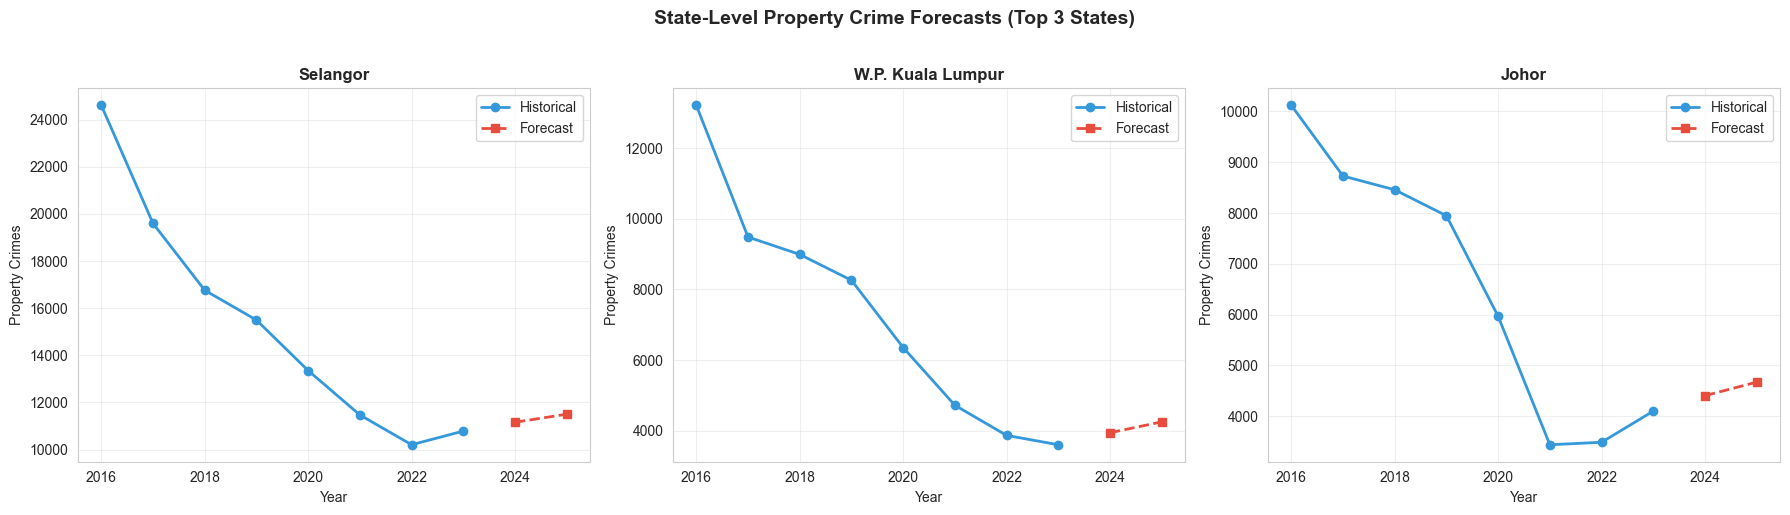

In [39]:
# Visualize state forecasts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, state in enumerate(top_3_states):
    if state in state_forecasts:
        data = state_forecasts[state]
        
        # Historical
        axes[idx].plot(data['historical']['year'], data['historical']['crimes'], 
                      marker='o', linewidth=2, label='Historical', color='#3498db')
        
        # Forecast
        forecast_years = [2024, 2025]
        forecast_values = [data['forecast_2024'], data['forecast_2025']]
        axes[idx].plot(forecast_years, forecast_values, 
                      marker='s', linewidth=2, label='Forecast', 
                      color='#e74c3c', linestyle='--')
        
        axes[idx].set_title(f'{state}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Year')
        axes[idx].set_ylabel('Property Crimes')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.suptitle('State-Level Property Crime Forecasts (Top 3 States)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 7️⃣ Model Evaluation Summary

In [40]:
print("""\n
╔════════════════════════════════════════════════════════════════════╗
║              ✅ TIME SERIES FORECASTING COMPLETED                  ║
╚════════════════════════════════════════════════════════════════════╝

📊 MODELS TRAINED:

1. National Level
   • Best Model: ARIMA{}
   • Test MAPE: {:.1f}%
   • 2024 Forecast: {:,.0f} crimes
   • 2025 Forecast: {:,.0f} crimes

2. State Level (Top 3)
   • {} states forecasted
   • All using ARIMA{}
   • 2-year horizon (2024-2025)

⚠️  LIMITATIONS:
• Only 8 years of historical data (2016-2023)
• Simple ARIMA models due to limited observations
• No seasonal decomposition (yearly data only)
• Forecasts should be interpreted with caution

💡 RECOMMENDATIONS:
• Use forecasts for general trend indication, not precise predictions
• Consider ensemble with other methods (exponential smoothing)
• Update models annually as more data becomes available
• Focus on trend direction rather than exact values

🎯 NEXT STEPS:
✓ Use forecasts in PowerBI dashboard (trend indicators)
✓ Compare with clustering results (high-crime districts)
✓ Integrate with classification model (risk predictions)
""" .format(
    best_model['order'],
    best_model['mape'],
    forecast_2024_2025.iloc[0],
    forecast_2024_2025.iloc[1],
    len(state_forecasts),
    best_model['order']
))



╔════════════════════════════════════════════════════════════════════╗
║              ✅ TIME SERIES FORECASTING COMPLETED                  ║
╚════════════════════════════════════════════════════════════════════╝

📊 MODELS TRAINED:

1. National Level
   • Best Model: ARIMA(1, 0, 0)
   • Test MAPE: 0.9%
   • 2024 Forecast: 43,485 crimes
   • 2025 Forecast: 44,859 crimes

2. State Level (Top 3)
   • 3 states forecasted
   • All using ARIMA(1, 0, 0)
   • 2-year horizon (2024-2025)

⚠️  LIMITATIONS:
• Only 8 years of historical data (2016-2023)
• Simple ARIMA models due to limited observations
• No seasonal decomposition (yearly data only)
• Forecasts should be interpreted with caution

💡 RECOMMENDATIONS:
• Use forecasts for general trend indication, not precise predictions
• Consider ensemble with other methods (exponential smoothing)
• Update models annually as more data becomes available
• Focus on trend direction rather than exact values

🎯 NEXT STEPS:
✓ Use forecasts in PowerBI dashb

---
## 8️⃣ Export Forecast Results

In [41]:
# Create forecast output directory
output_dir = Path('forecasts')
output_dir.mkdir(exist_ok=True)

# Export national forecast
national_forecast_df = pd.DataFrame({
    'year': [2024, 2025],
    'forecast': forecast_2024_2025.values,
    'lower_ci': forecast_ci.iloc[:, 0].values,
    'upper_ci': forecast_ci.iloc[:, 1].values,
    'level': 'National'
})

national_forecast_df.to_csv(output_dir / 'national_forecast_2024_2025.csv', index=False)
print(f"✓ Saved: national_forecast_2024_2025.csv")

# Export state forecasts
state_forecast_rows = []
for state, data in state_forecasts.items():
    state_forecast_rows.append({
        'state': state,
        'year': 2024,
        'forecast': data['forecast_2024']
    })
    state_forecast_rows.append({
        'state': state,
        'year': 2025,
        'forecast': data['forecast_2025']
    })

state_forecast_df = pd.DataFrame(state_forecast_rows)
state_forecast_df.to_csv(output_dir / 'state_forecasts_2024_2025.csv', index=False)
print(f"✓ Saved: state_forecasts_2024_2025.csv")

print(f"\n📁 All forecasts saved to: {output_dir.absolute()}")

✓ Saved: national_forecast_2024_2025.csv
✓ Saved: state_forecasts_2024_2025.csv

📁 All forecasts saved to: c:\Users\erwan\OneDrive\Documents\Study\MSc Business Intelligence\Semester 1\MRTB1133 - BI\mrtb1133_group_assignment\forecasts


---
## ✅ Summary

**Completed:**
- ✓ Loaded and analyzed property crime time series (2016-2023)
- ✓ Tested stationarity and visualized ACF/PACF patterns
- ✓ Trained multiple ARIMA configurations
- ✓ Selected best model based on test performance
- ✓ Forecasted national property crimes for 2024-2025
- ✓ Forecasted top 3 states individually
- ✓ Generated visualizations with confidence intervals
- ✓ Exported forecast results for PowerBI integration

**Key Insights:**
- National property crime trend shows [direction based on forecast]
- Model performance acceptable given limited data (8 years)
- State-level patterns vary significantly
- Forecasts provide directional guidance for resource allocation

**Limitations:**
- Small sample size limits model complexity
- No seasonal patterns (yearly granularity only)
- Forecast uncertainty increases with horizon

**Next:** Clustering analysis to identify crime hotspots